<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#HAC-post-hoc-pairewise-ttest" data-toc-modified-id="HAC-post-hoc-pairewise-ttest-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>HAC-post-hoc pairewise ttest</a></span></li></ul></div>

## HAC-post-hoc pairewise ttest

Vegetation index: kNDVI
Number of clusters: 3
Number of clusters: 4
Number of clusters: 5
Number of clusters: 6
Number of clusters: 7
Number of clusters: 8
Number of clusters: 9
Number of clusters: 10
Number of clusters: 11
Number of clusters: 12
Number of clusters: 13
Number of clusters: 14
Number of clusters: 15
Number of clusters: 16
Number of clusters: 17
Number of clusters: 18
Number of clusters: 19
Number of clusters: 20
Number of clusters: 21


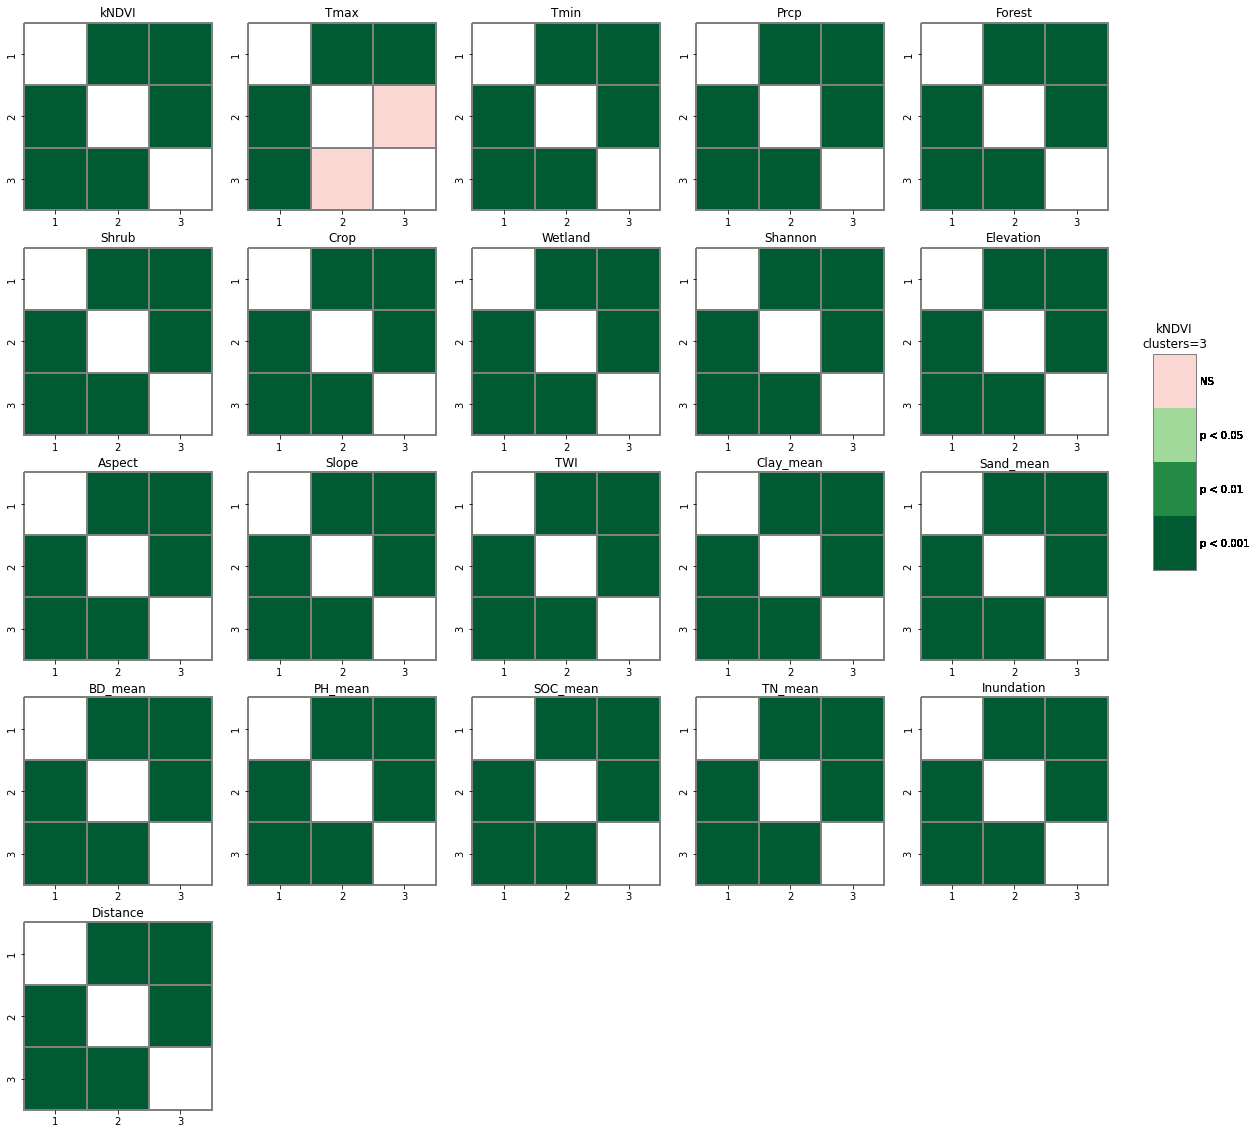

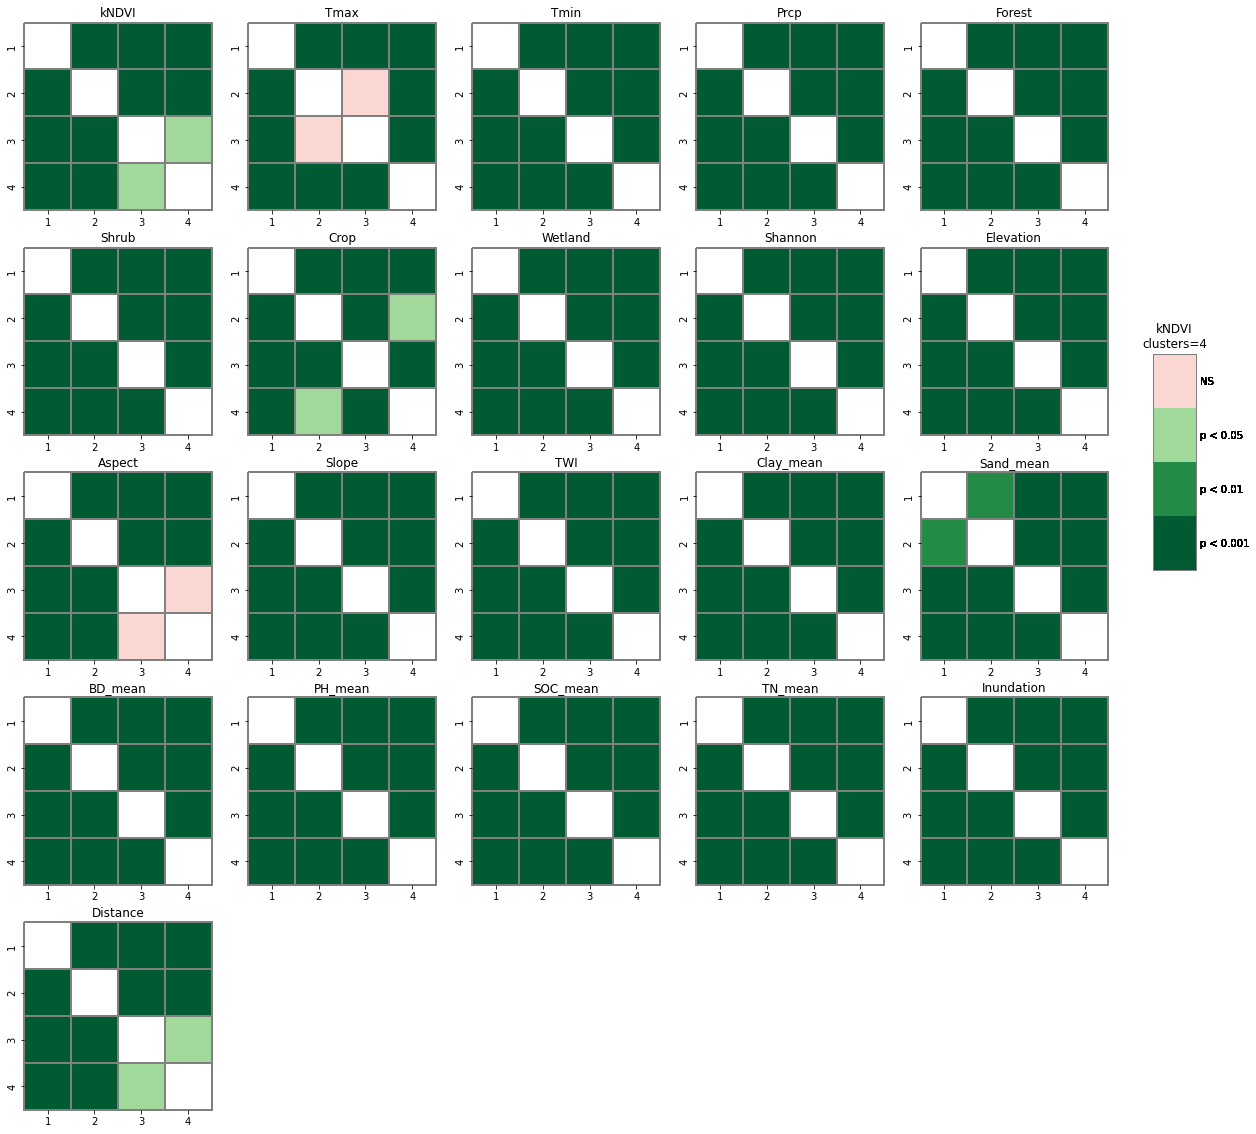

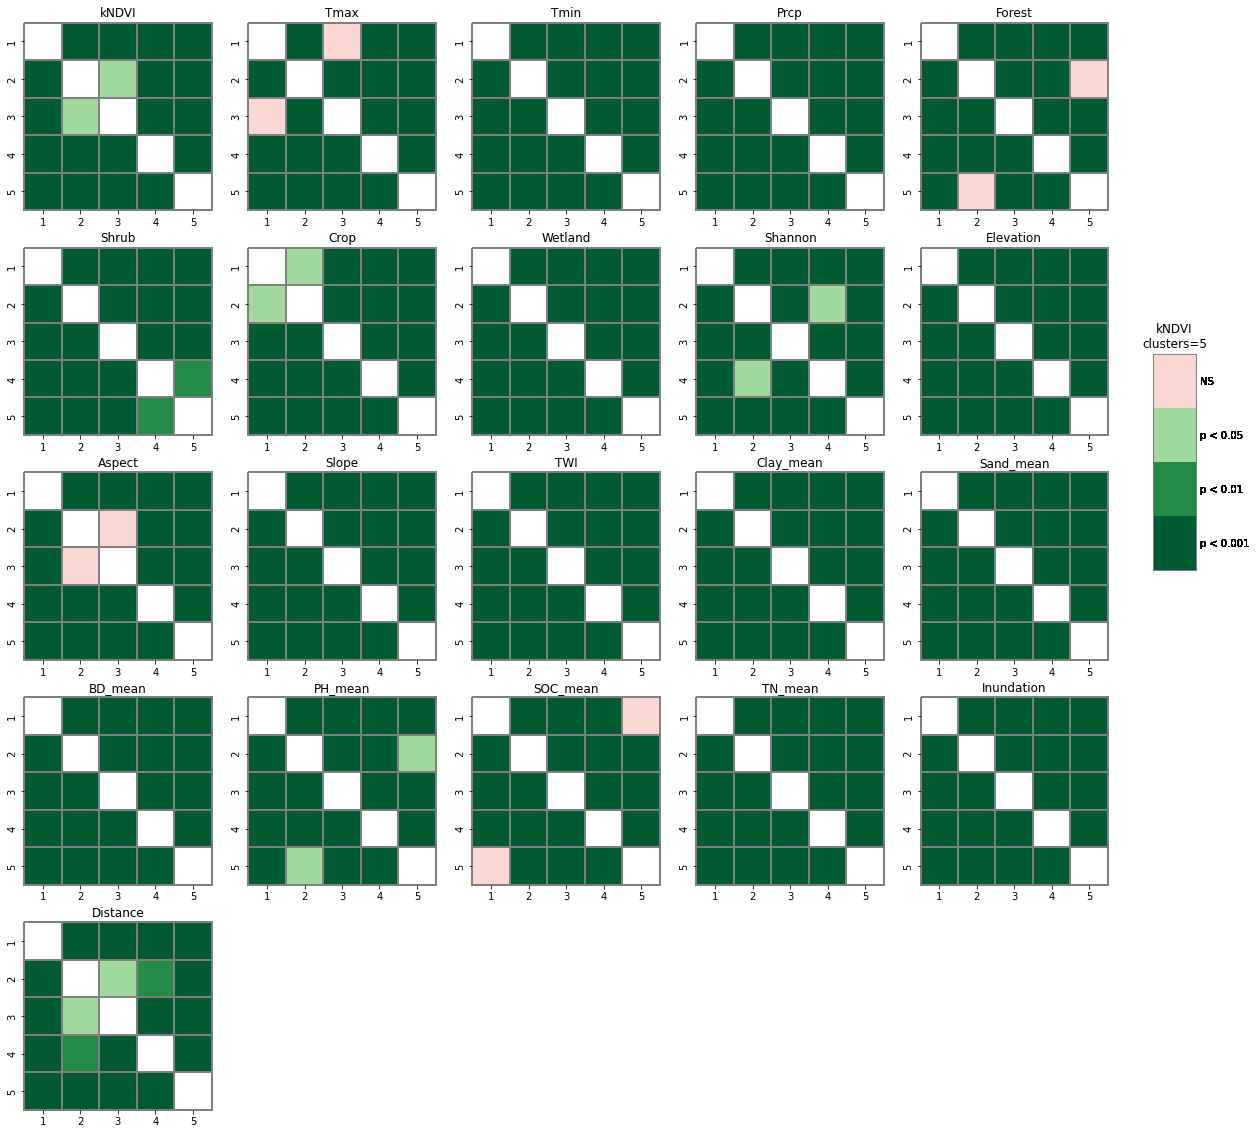

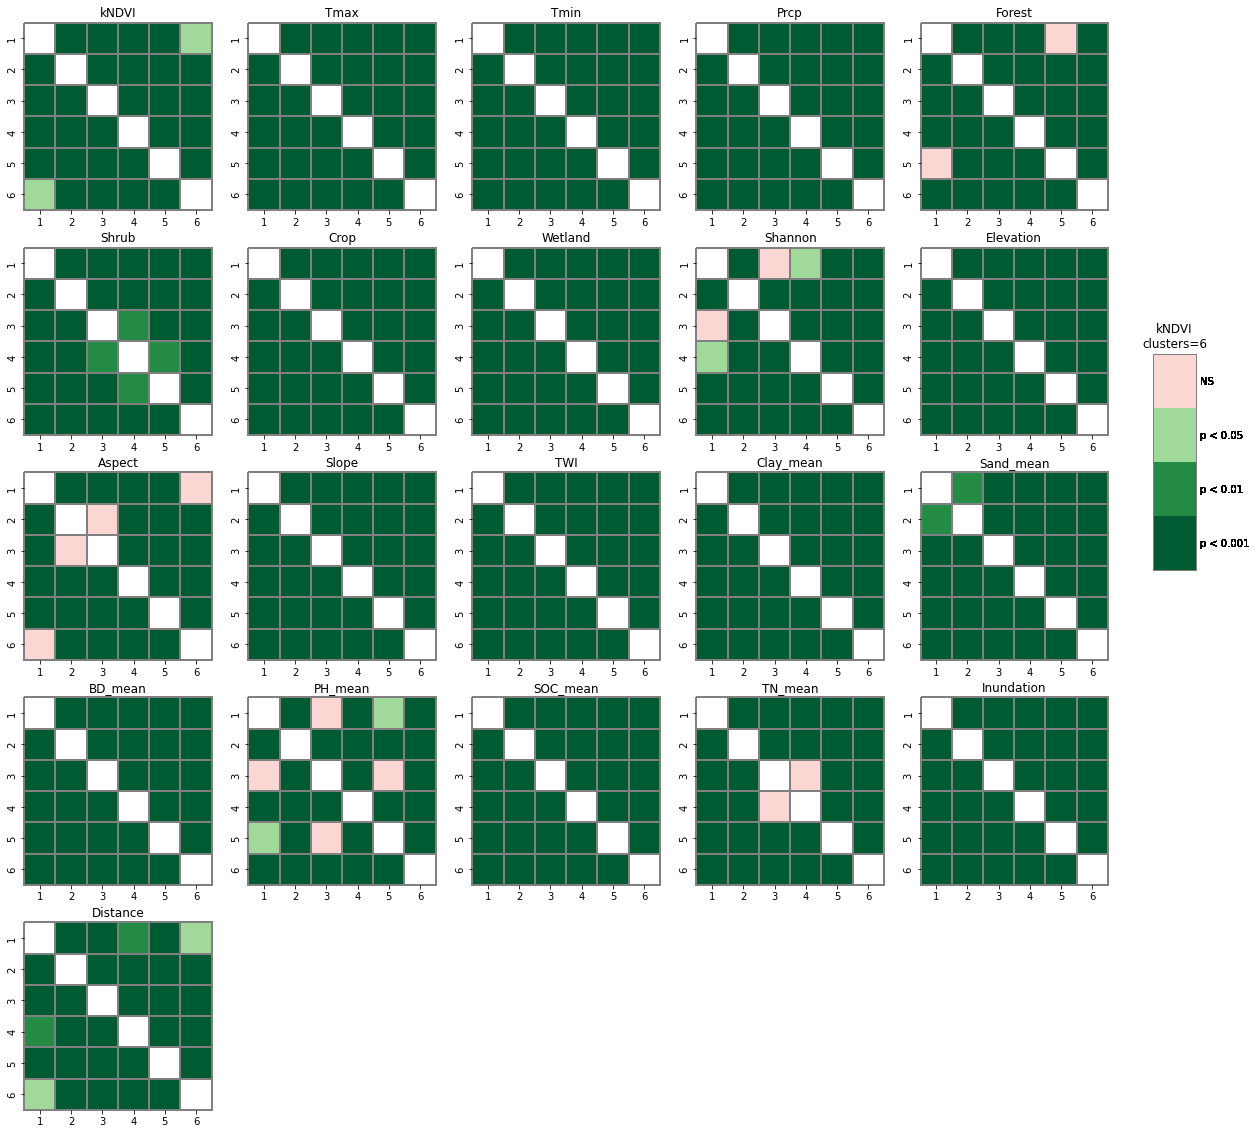

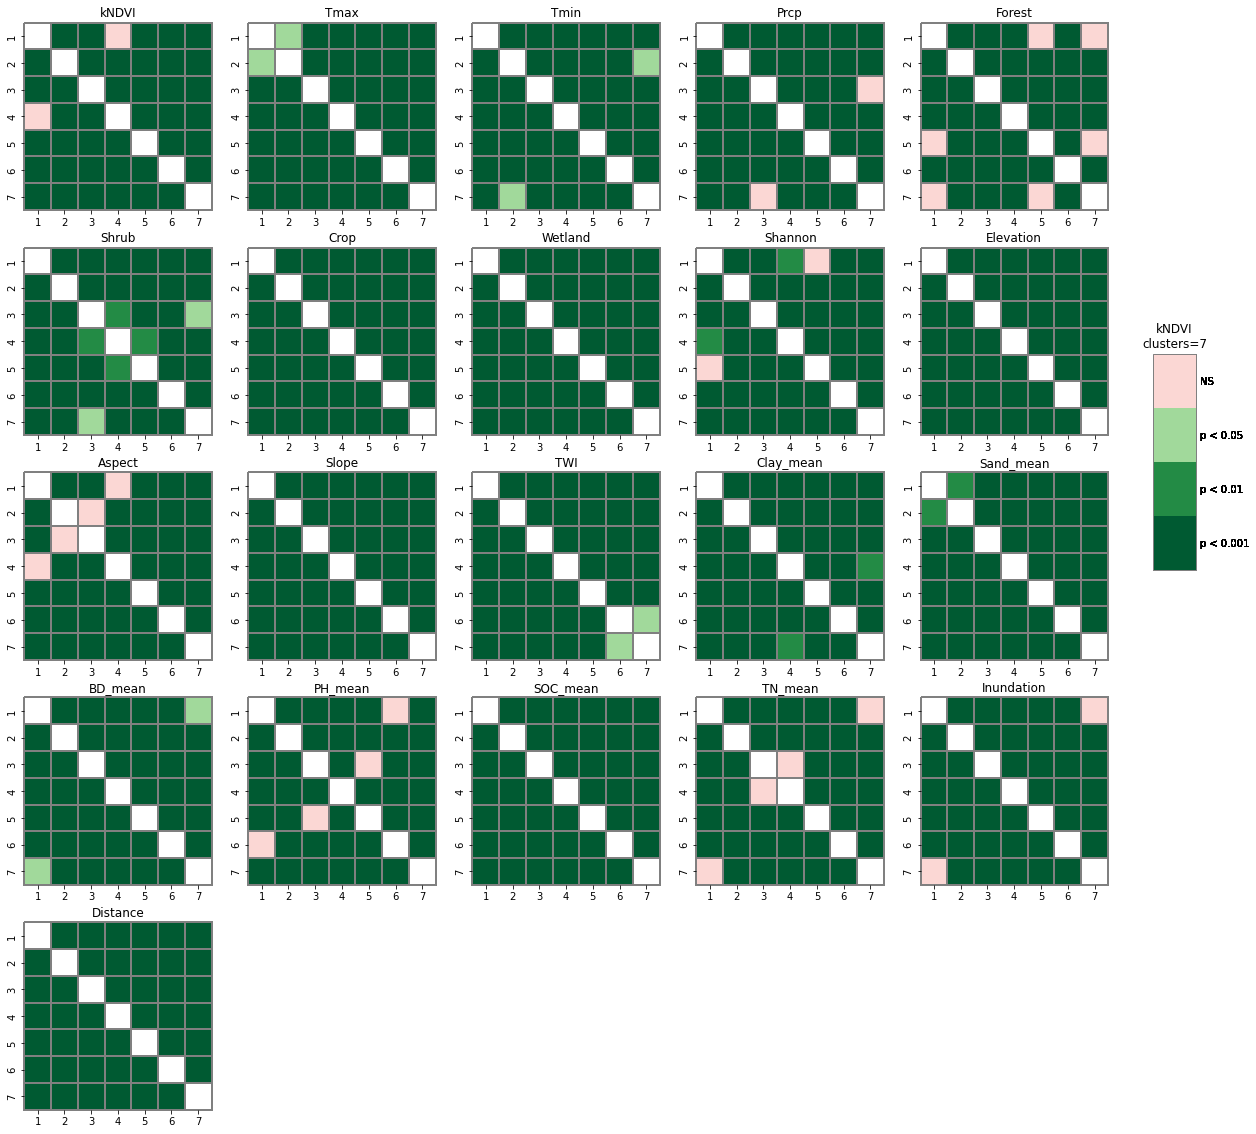

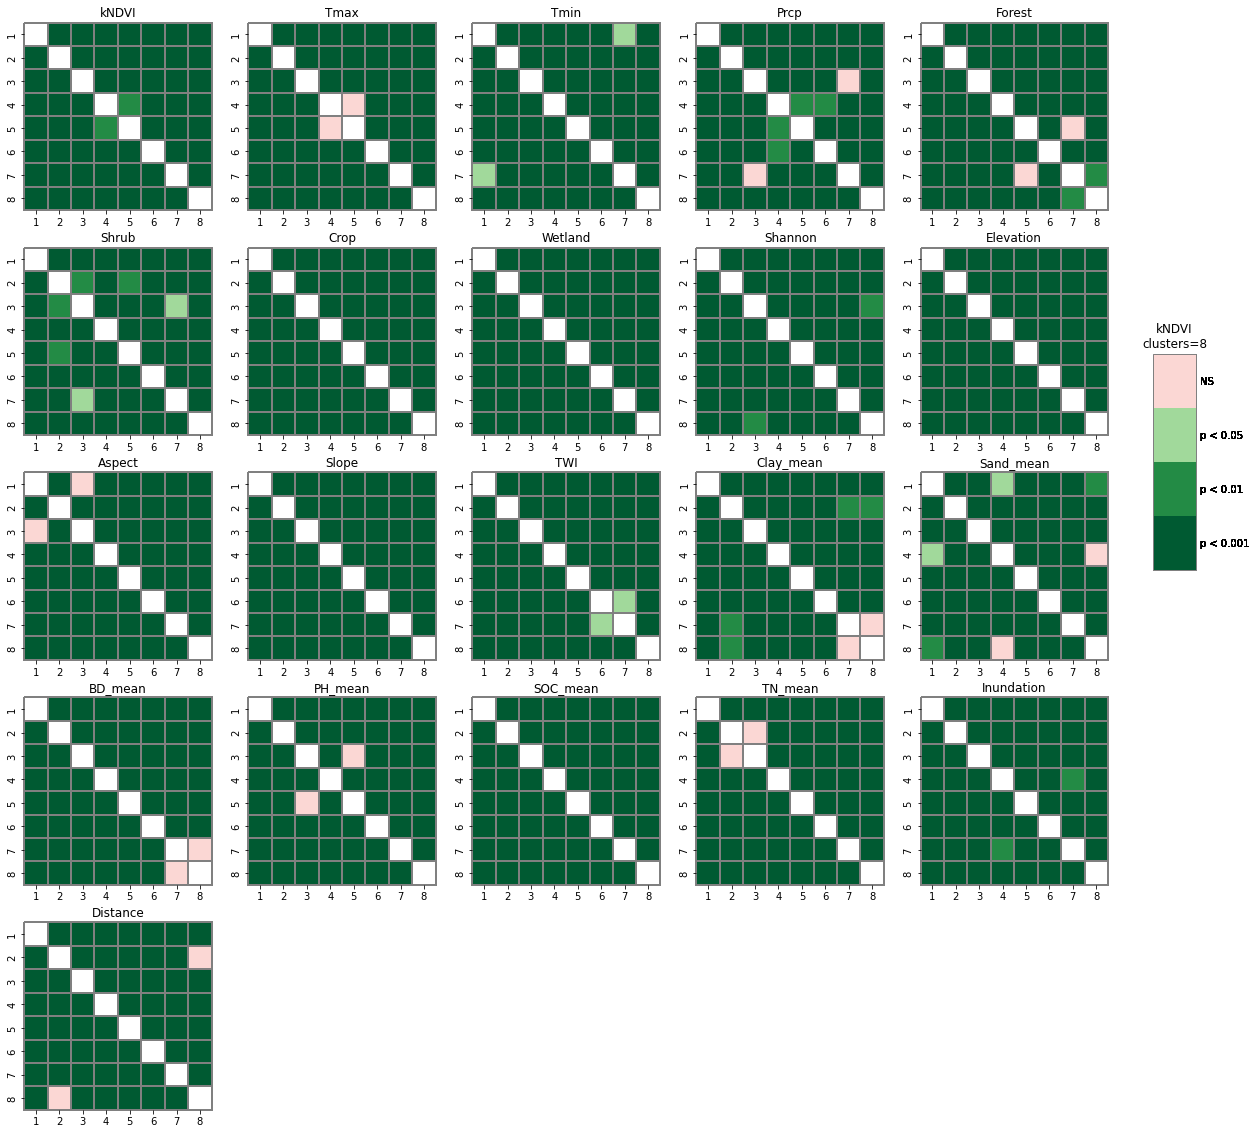

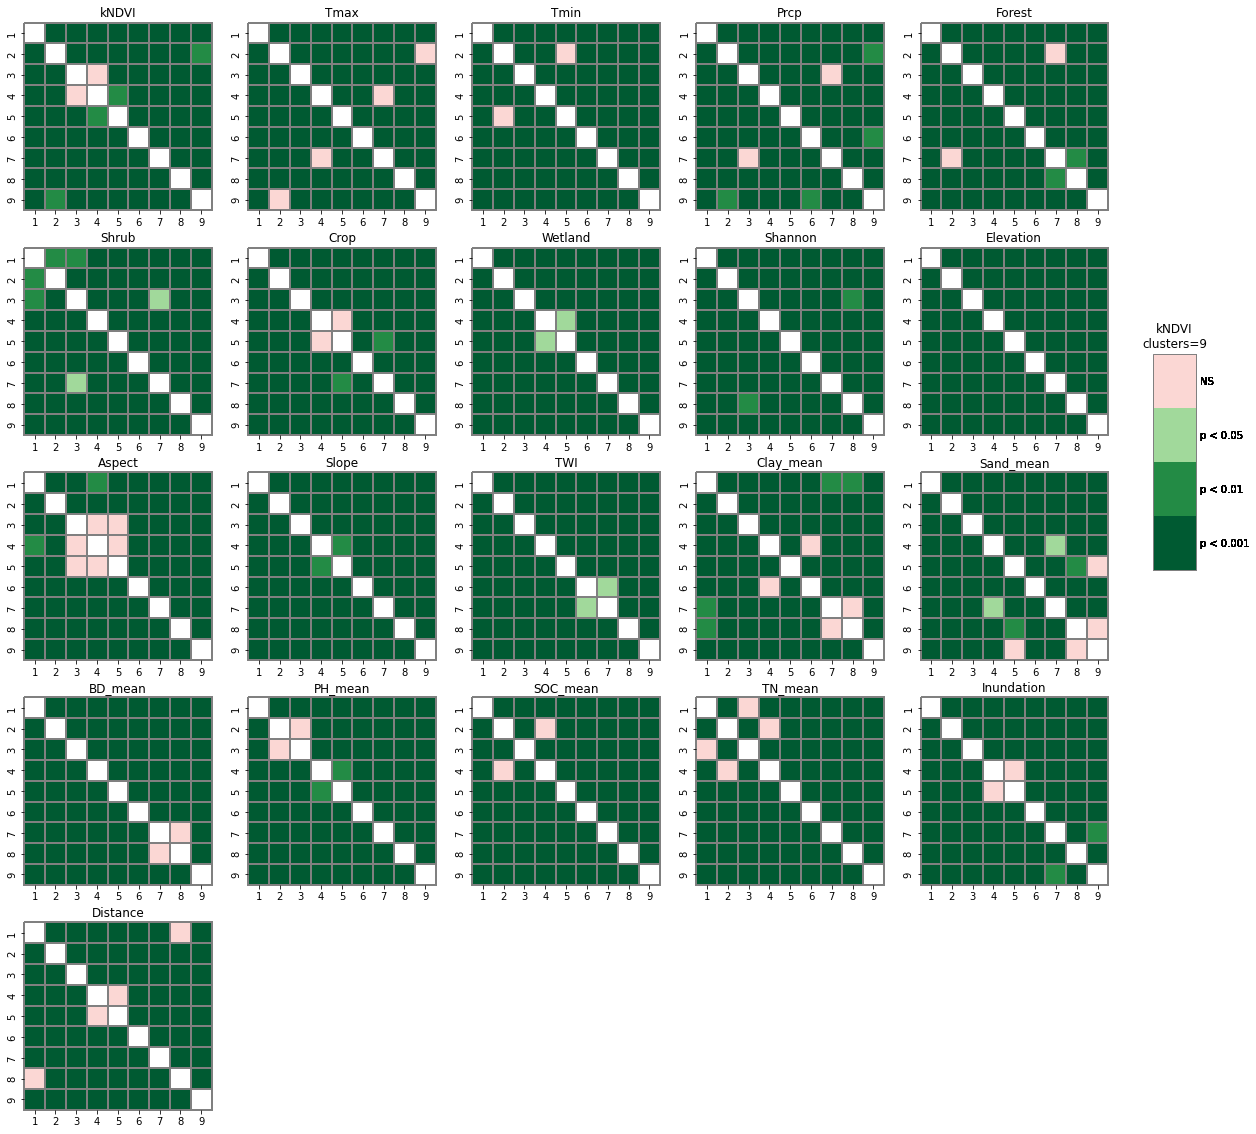

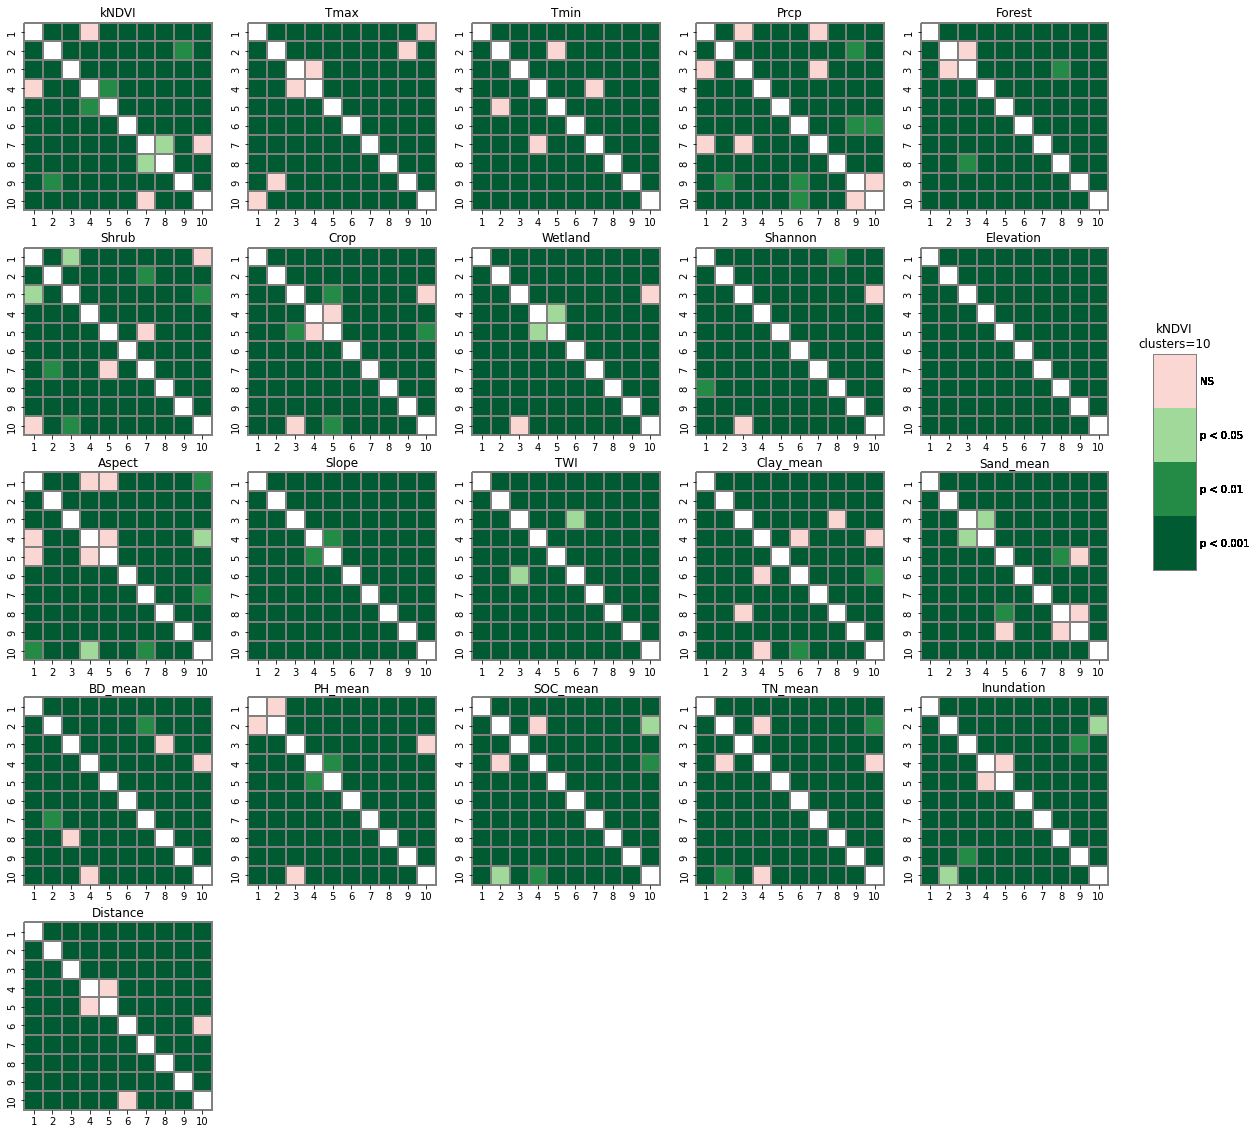

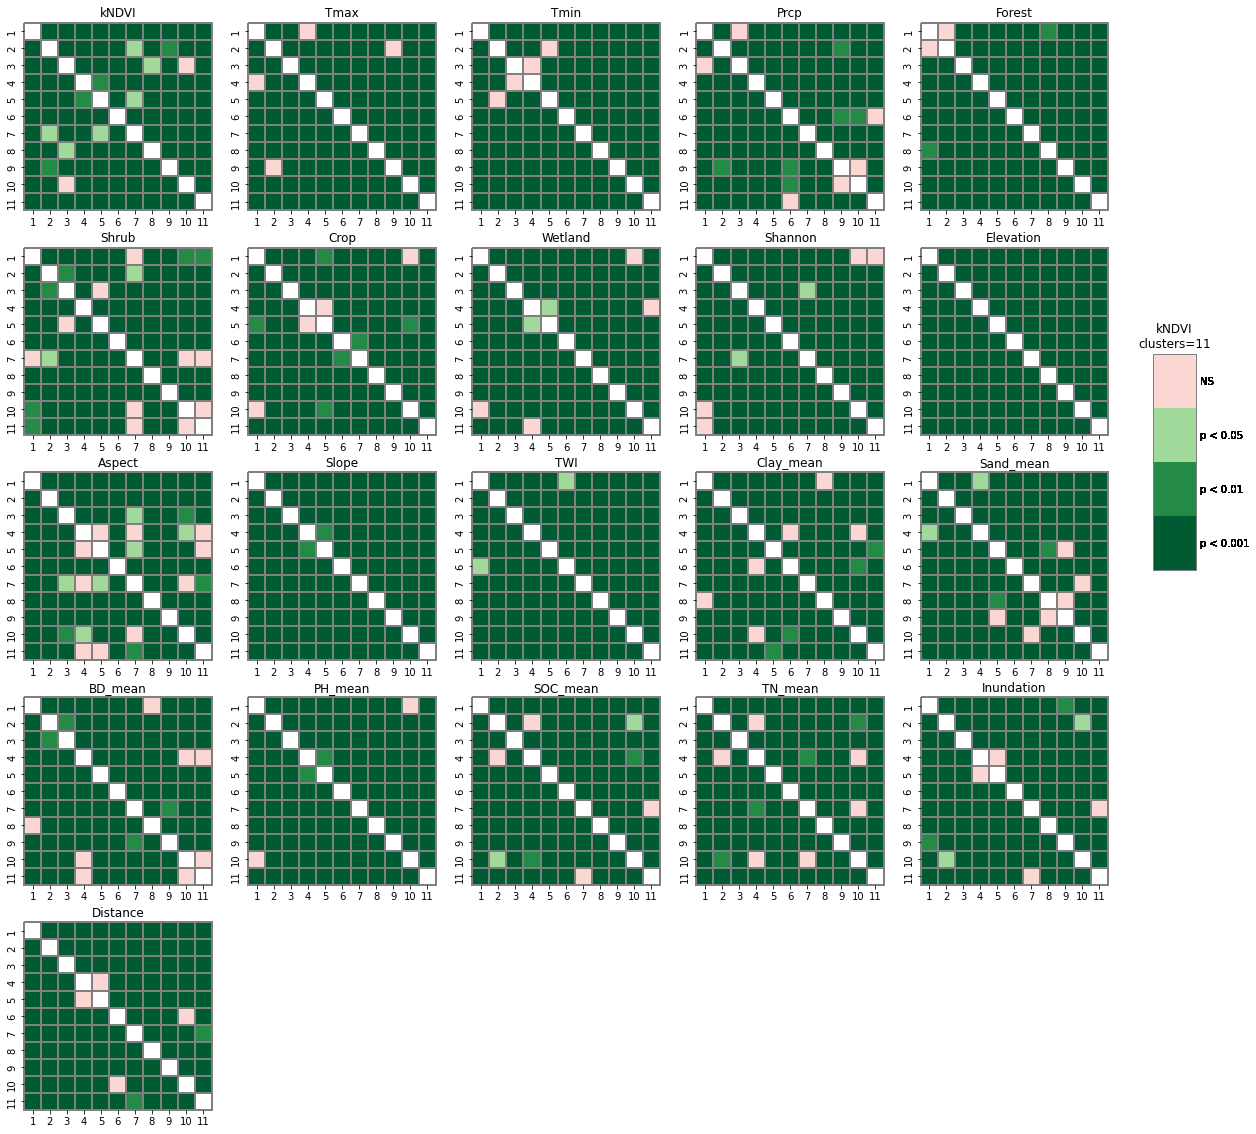

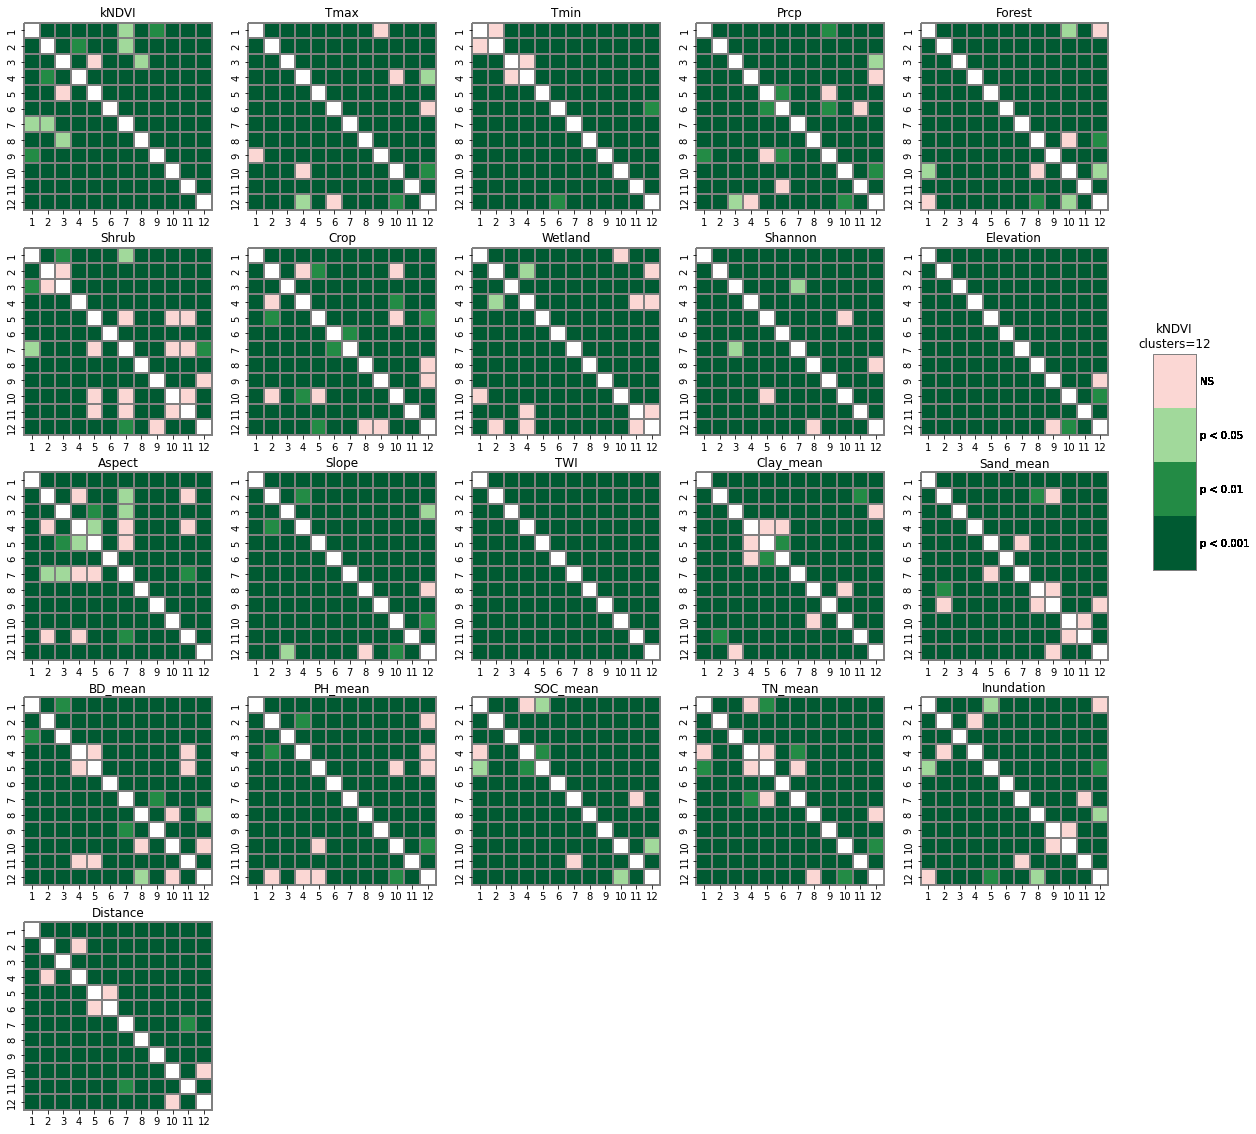

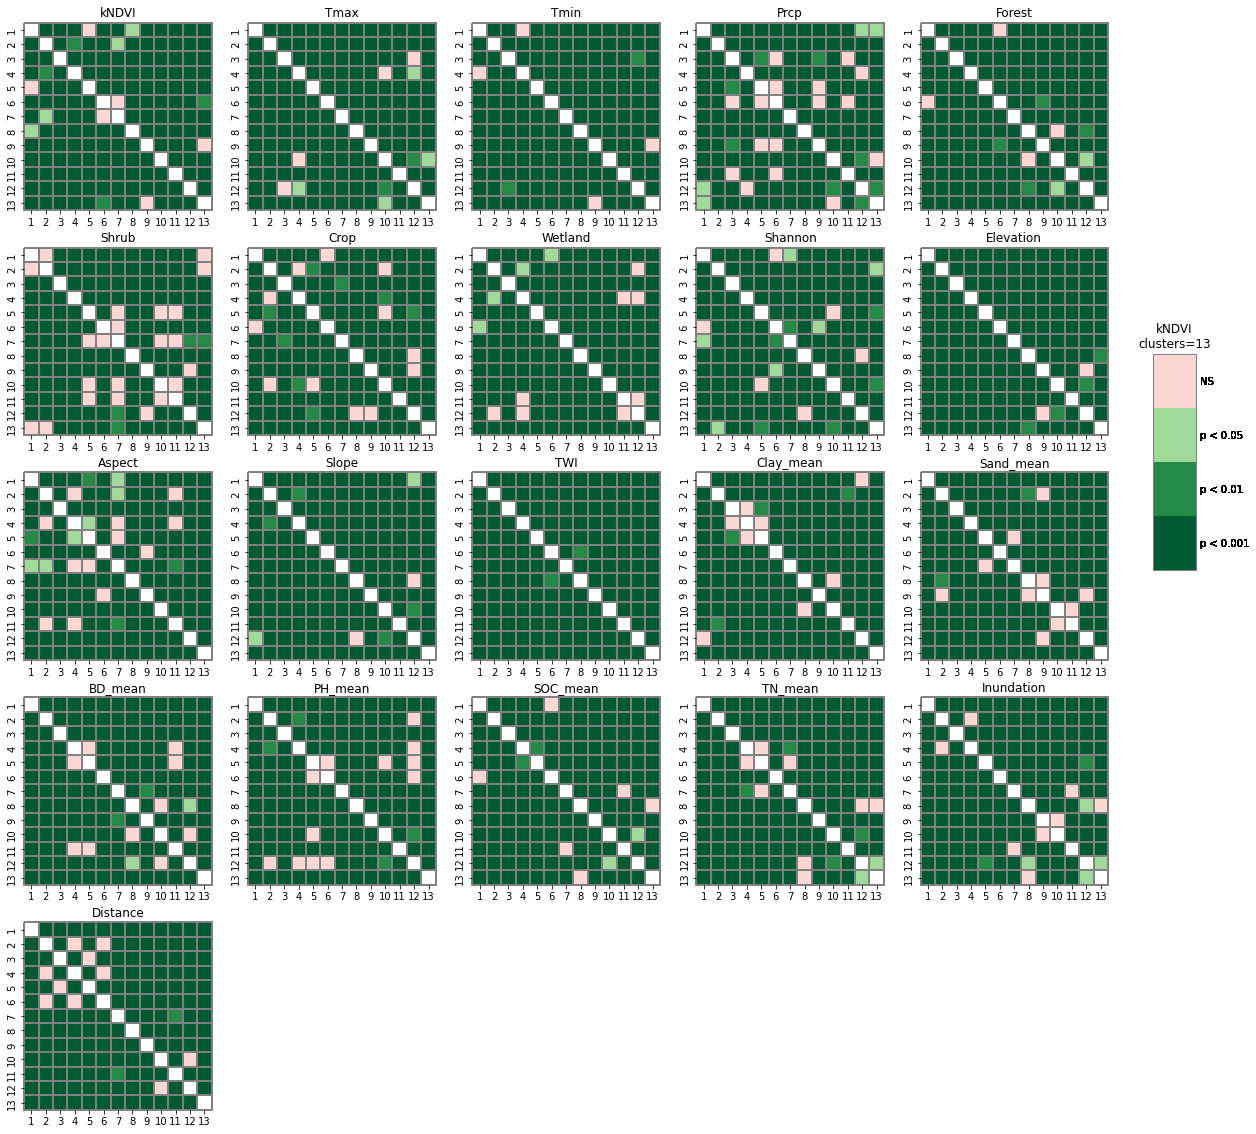

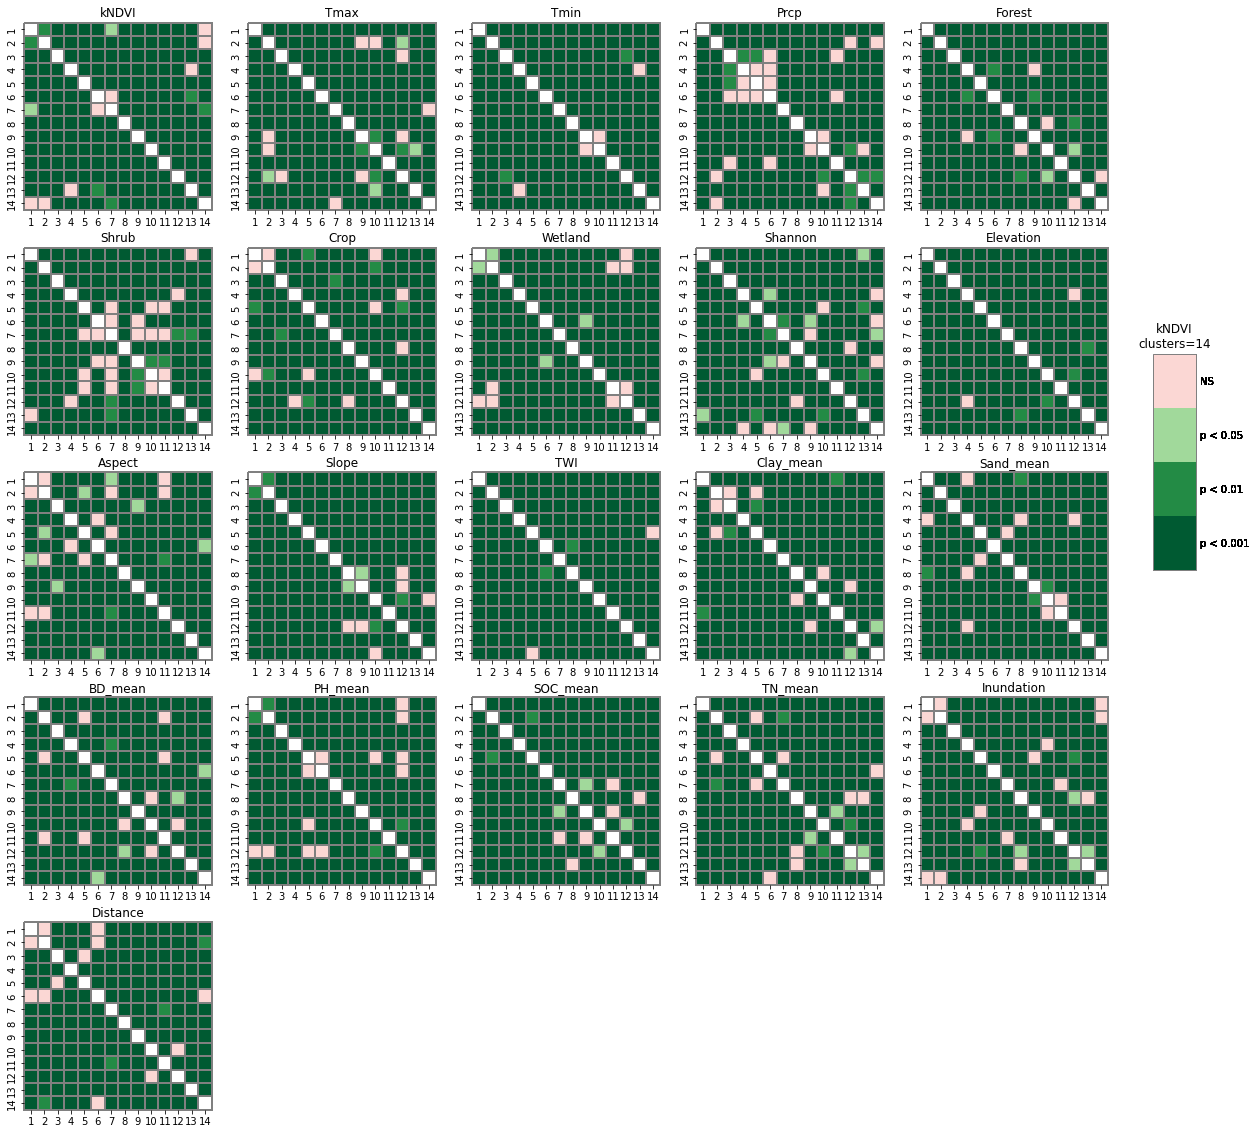

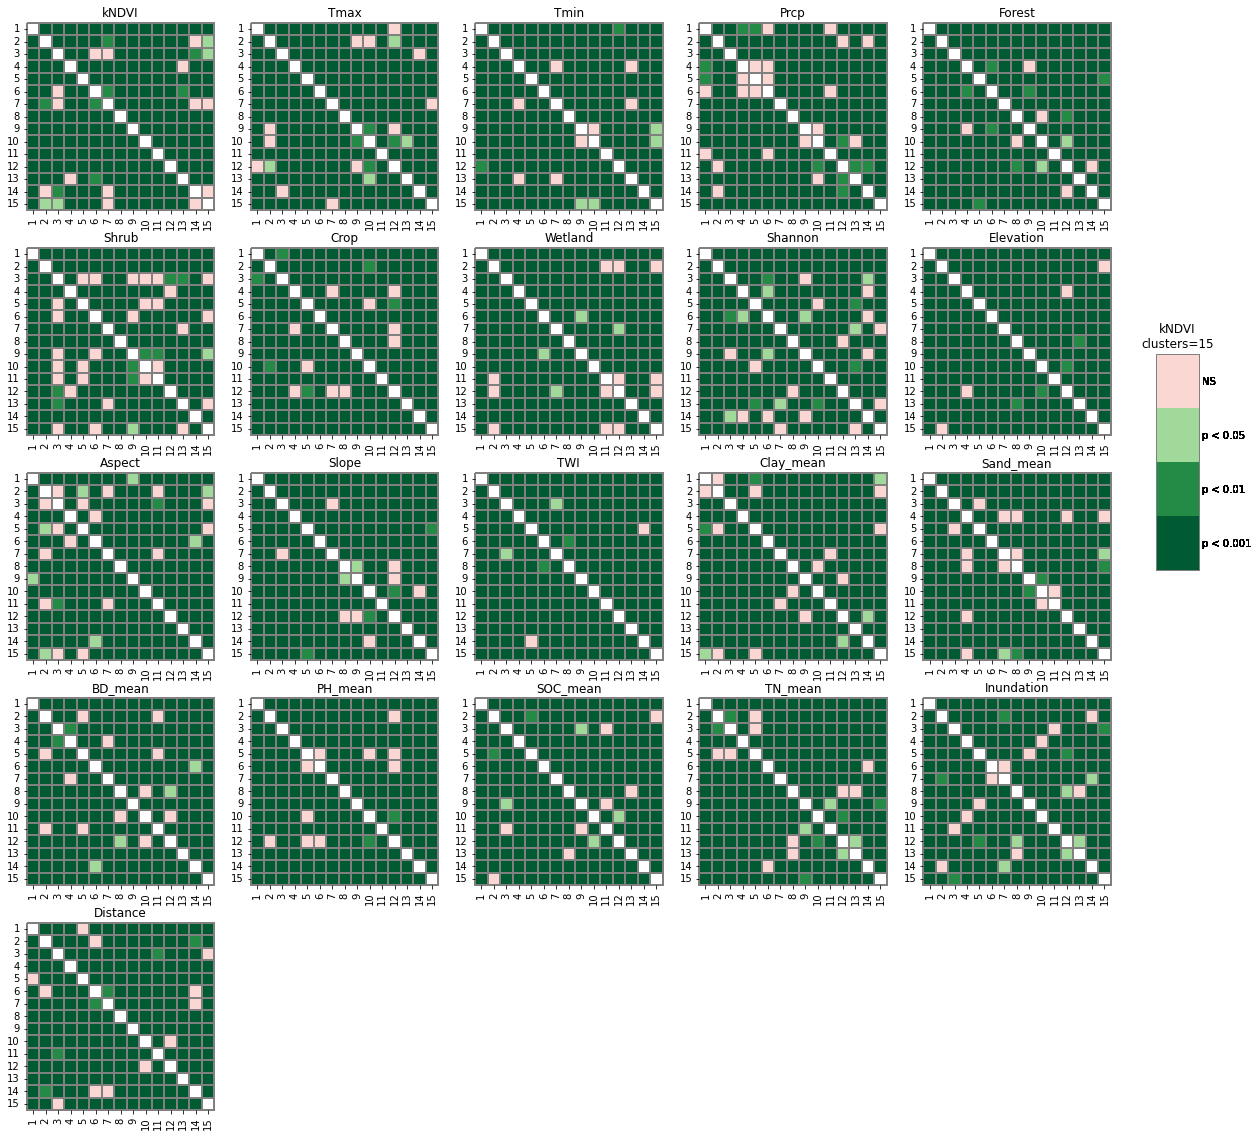

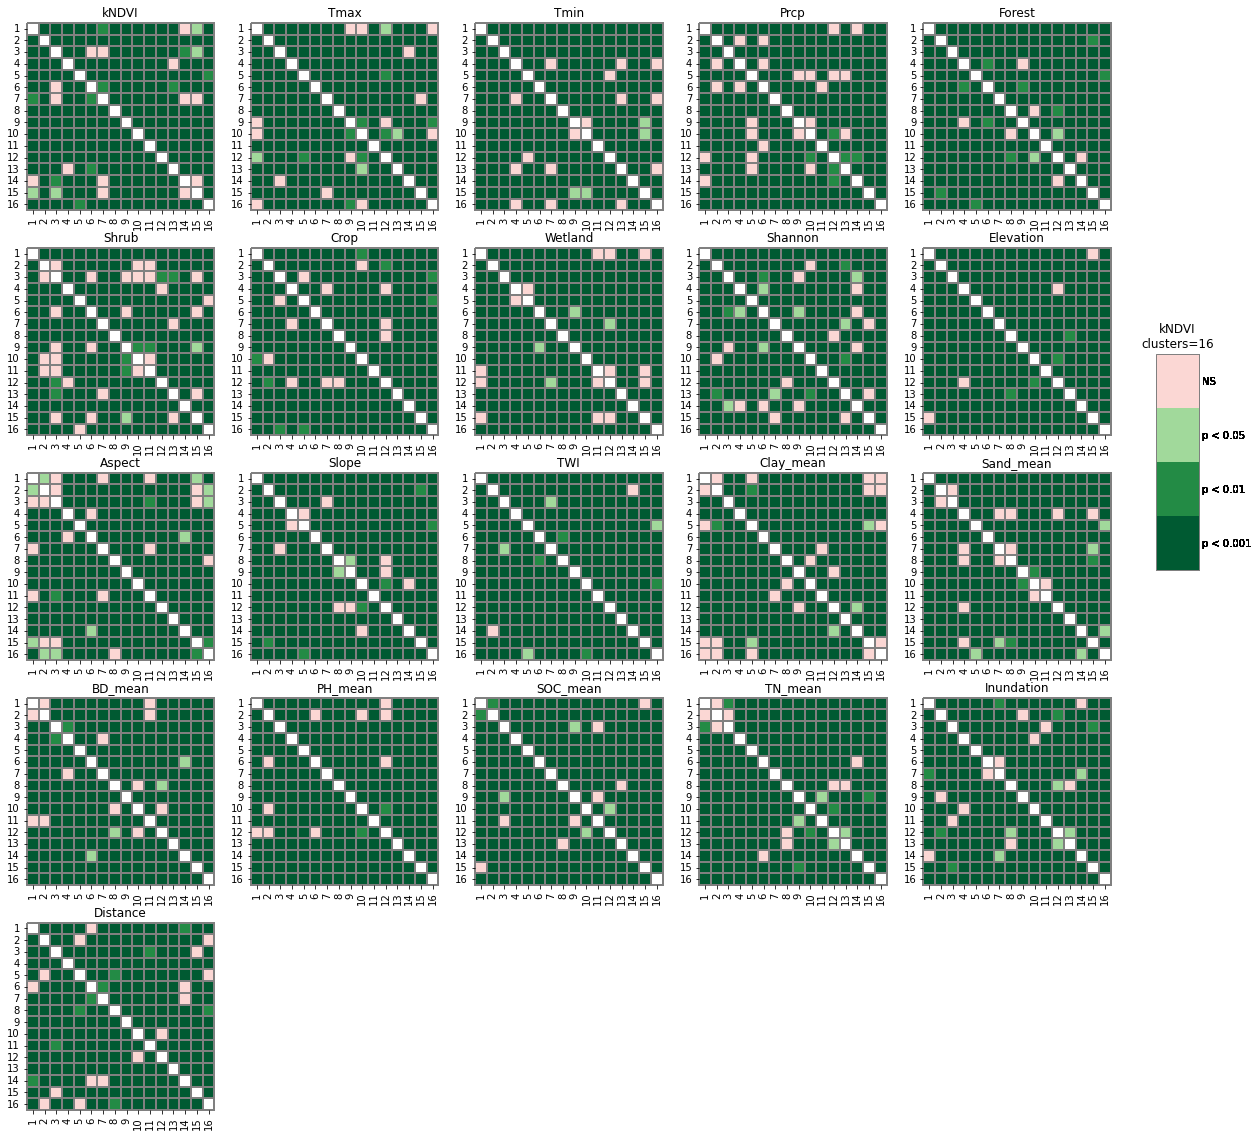

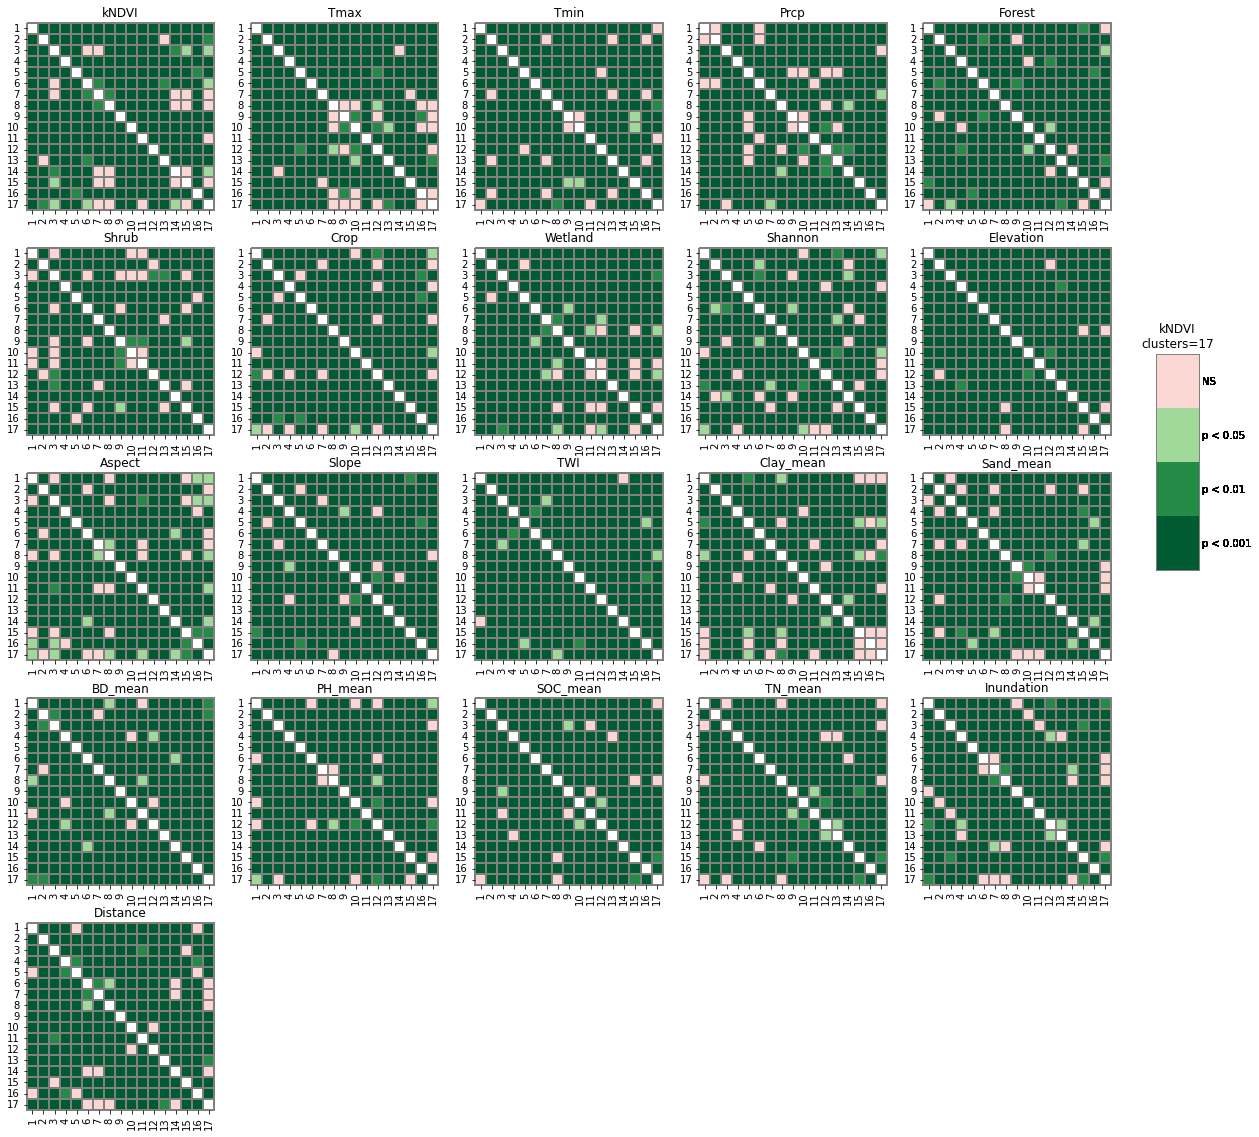

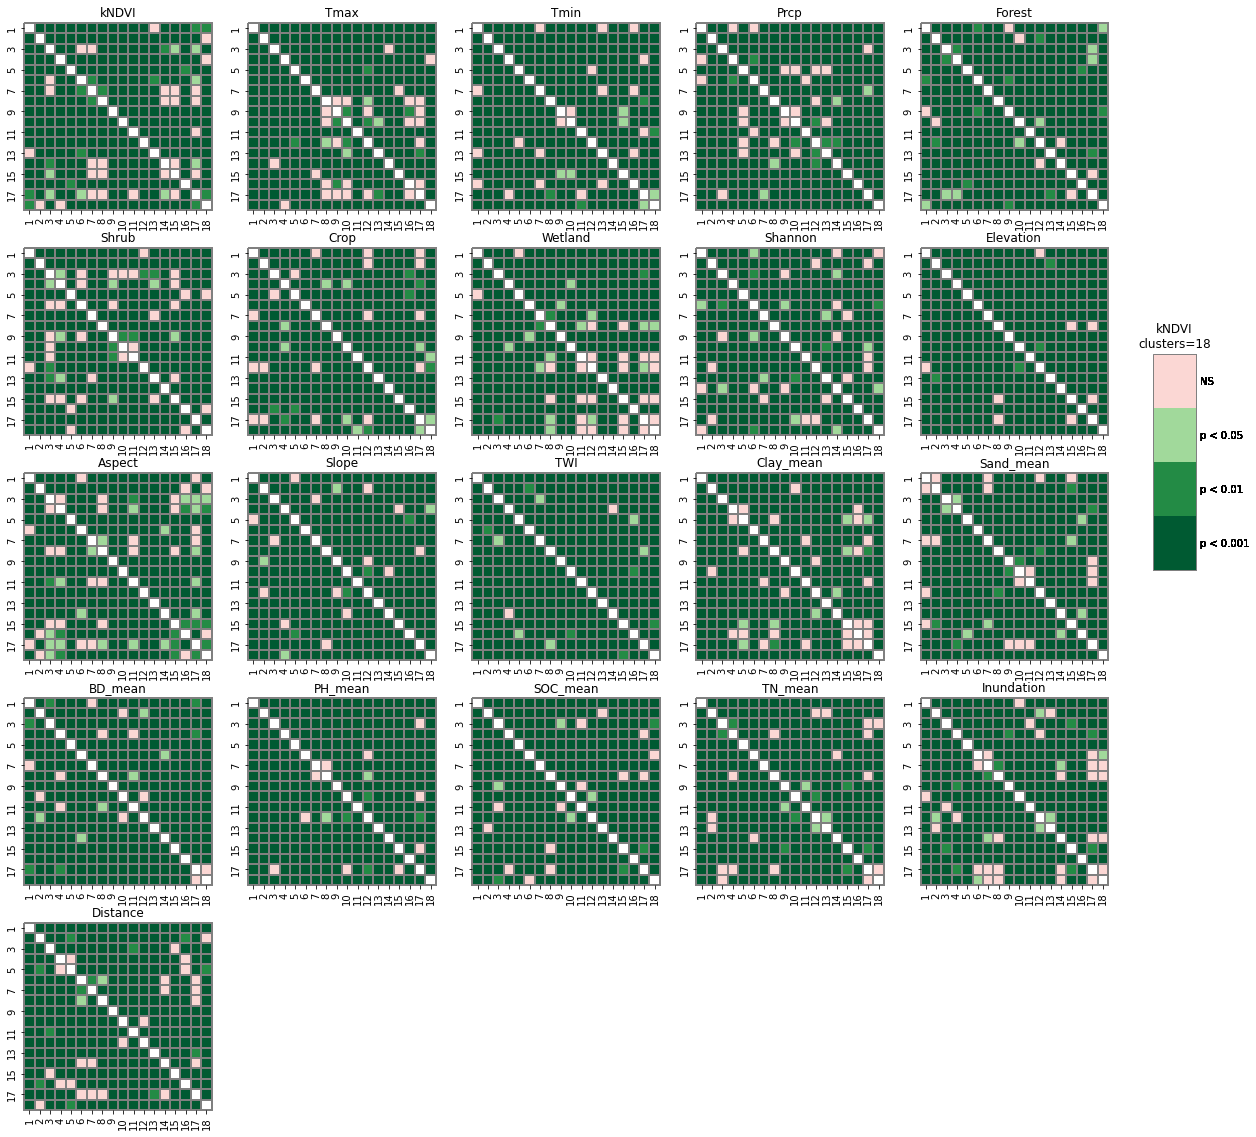

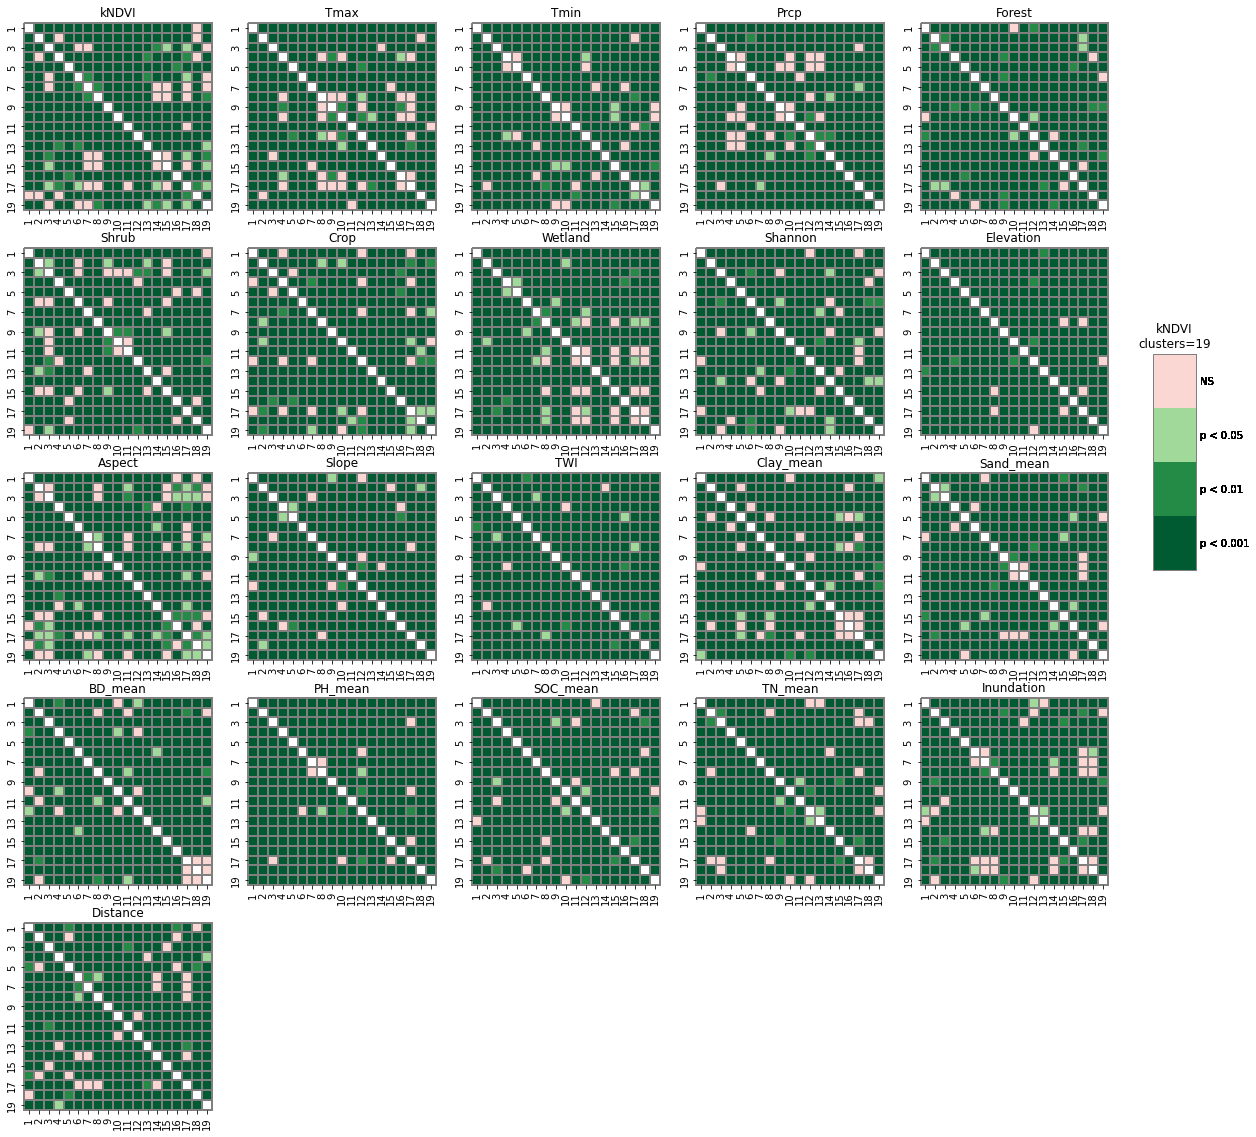

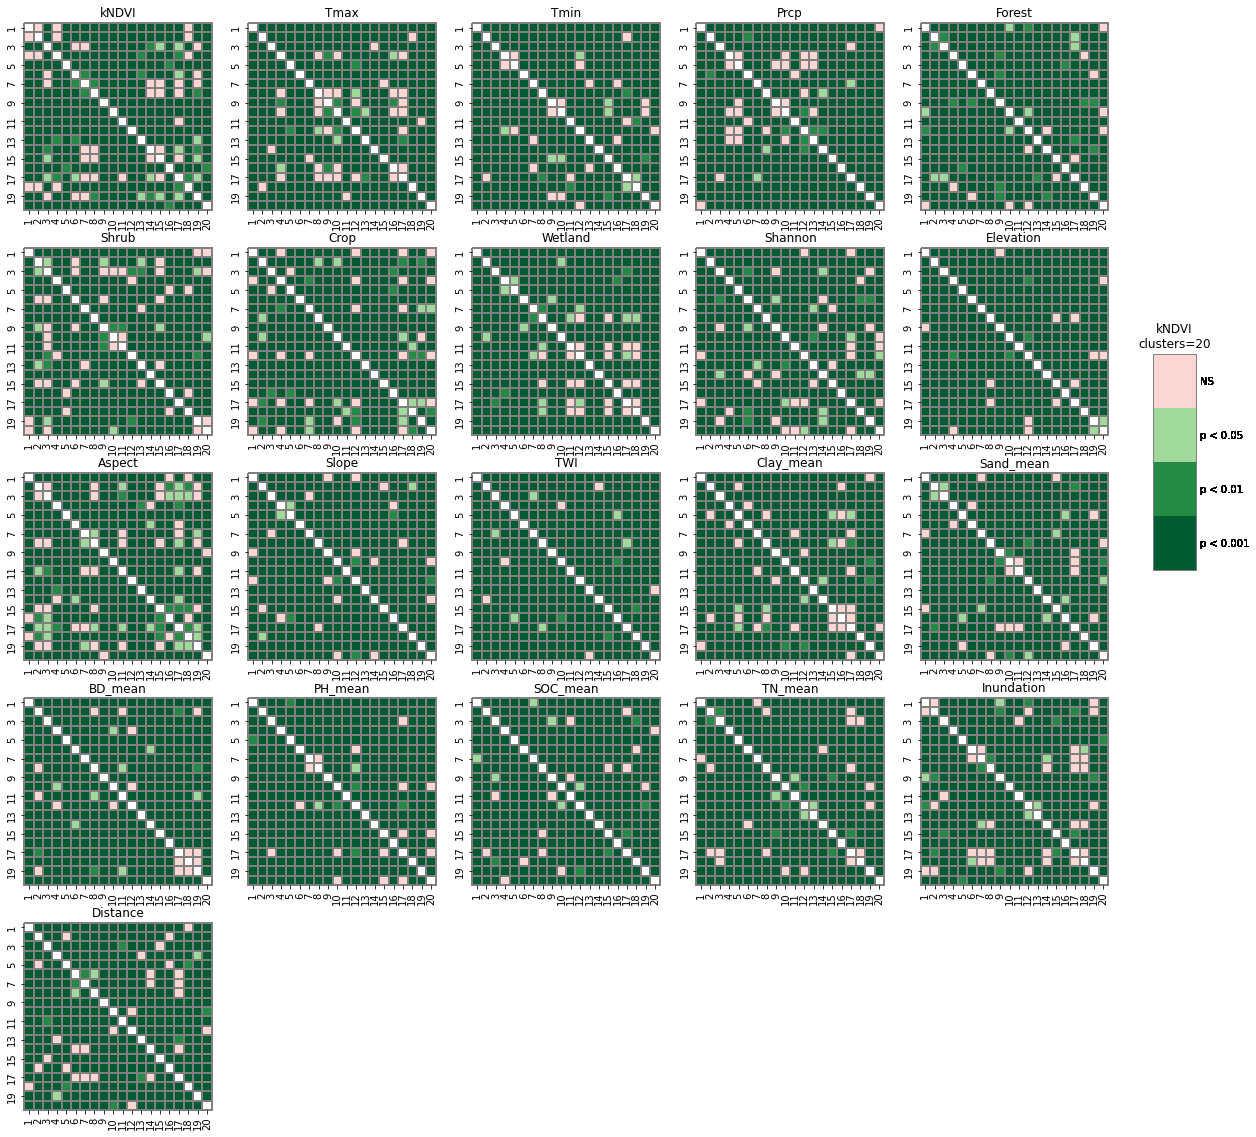

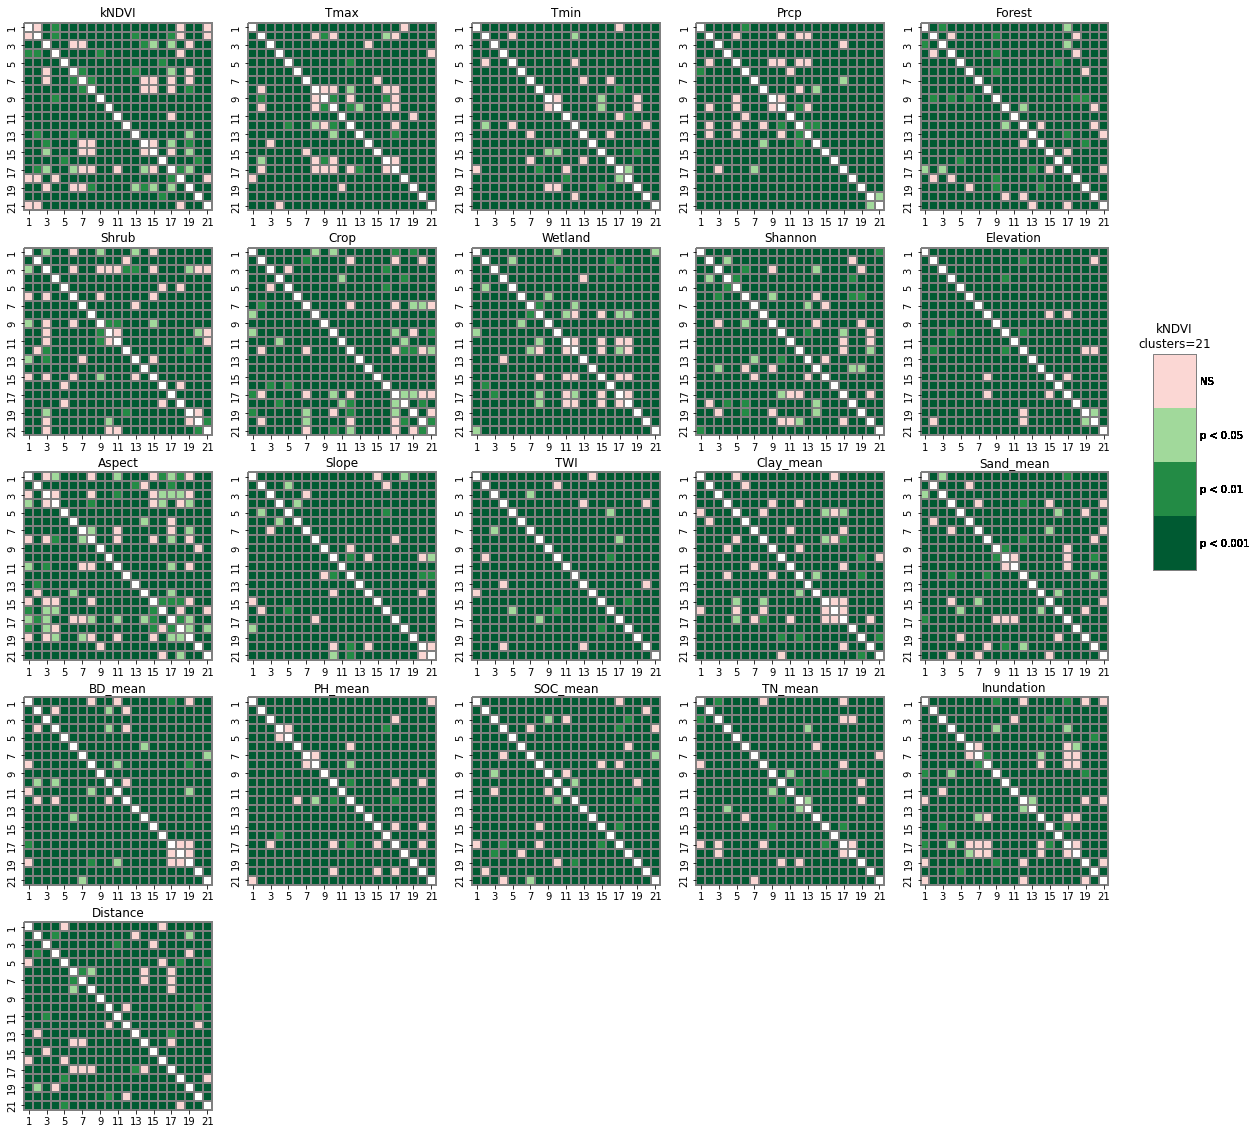

In [9]:
def pairewise_ttest_plot(indata, outpath, vegeidx, numcluster, numpca):
    """
    indata:      input shapefile dataset         --string
    outpath:     directory of output path        --string
    vegeidx:     vegetation index                --string
    numcluster:  number of clusters              --int
    numpca:      principle component analysis    --int
    """
    
    import matplotlib.pyplot as plt
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import scikit_posthocs as sp
    import numpy as np
    import pandas as pd
    import geopandas as gpd
    import os    
    
    # Load dataset
    df = gpd.read_file(indata)

    # Define and select features
    col_selec = ['kNDVI',
                 'Tmax', 'Tmin', 'Prcp',
                 'Forest', 'Shrub', 'Crop', 'Wetland',
                 'Shannon',
                 'Elevation', 'Aspect', 'Slope', 'TWI',
                 'Clay_mean', 'Sand_mean', 'BD_mean', 'PH_mean', 'SOC_mean', 'TN_mean',
                 'Inundation',
                 'Distance'
                ]

    # Choose dataset by col_selec
    df = df[col_selec]

    df_sel = df[col_selec]
    # Standardize
    sc = StandardScaler()
    df_scaled = sc.fit_transform(df_sel)
    
    # PCA
    pca = PCA(n_components=numpca)

    # Transform
    pca_ = pca.fit_transform(df_scaled,)
    df_pca = pd.DataFrame(pca_, columns=[f'PCA{i+1}' for i in range(0, numpca)])    
    
    # Clustering
    cluster_pca = AgglomerativeClustering(linkage="ward", n_clusters=numcluster).fit(df_pca)
        
    # Assign clustering result to dataframe
    cluster_labels = cluster_pca.labels_
    df['cluster'] = cluster_pca.labels_ + 1
    df = df.sort_values('cluster')
     
    # Turn off interactive display
    plt.ioff()   
    
    # Define subplot layout
    rows, cols = 5, 5
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=[20, 20]) 
    plt.subplots_adjust(hspace=0.2, wspace=0.02)
    
    # Build a new dataframe
    newdf = pd.DataFrame(columns=['Numcluster', 'Feature', 'Ratio'])

    for num, feature in enumerate(df.columns):
        if feature not in ["cluster"]:
            # Calculate t-test
            pc = sp.posthoc_ttest(df, val_col=feature, group_col='cluster')
            
            # Count the values < 0.05
            count = (pc < 0.05).sum().sum()
            
            # Count the non-diagonal values
            total = pc.shape[0] * (pc.shape[1] - 1)
            
            # Calculate the ratio
            ratio = count / total
            
            # Build a new row dictionary
            new_row = {'Numcluster': numcluster, 'Feature': feature, 'Ratio': ratio}
                   
            # Add new_row to newdf
            newdf = newdf.append(new_row, ignore_index=True)
            
            # Plot
            heatmap_args = {'linewidths': 0.25, 
                            'linecolor': '0.5', 
                            'clip_on': False, 
                            'square': True,
                            'cbar_ax_bbox': [0.92, 0.5, 0.03, 0.15]  # [x-axis, y-axis, bar-width, bar-length]
                           }
            sp.sign_plot(pc, **heatmap_args, ax=axes.ravel()[num]) 
            axes.ravel()[num].set_title(f"{feature}")
    
    # Hide the extra plots
    for i in range(len(df.columns) - 1, rows * cols):
        axes.ravel()[i].set_visible(False)

    # Save the figure
    outname = os.path.join(outpath, f'ttest_pca_{vegeidx}_{numcluster}cluster.png')
    nl = '\n'
    plt.title(f'{vegeidx}{nl}clusters={numcluster}')
    plt.savefig(outname, format='png', dpi=100, bbox_inches=None, pad_inches=0.2) 
    
    return newdf


# Execute the function
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os 

# Specify the input parameters
indata = "/home/compass/CPB_vector.shp"
outpath = '/home/compass/out'
numpca = 12

for vegeidx in ["kNDVI"]:
    print("Vegetation index:", vegeidx)
    
    outdfname = os.path.join(outpath, f'ttest_std_{vegeidx}.csv')
    merged_df = pd.DataFrame()
    
    for numcluster in range(3, 22):
        print("Number of clusters:", numcluster)
        
        result_df = pairewise_ttest_plot(indata, outpath, vegeidx, numcluster, numpca)
        merged_df = merged_df.append(result_df)
    
    # Save the merged dataframe
    merged_df.to_csv(outdfname, index=False)


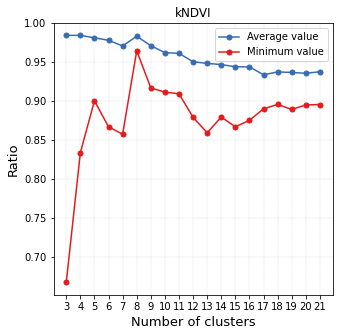

In [14]:
def sig_feature_ratio(indata, vegeidx, outpath):
    """
    indata:      input shapefile dataset         --string
    vegeidx:     vegetation index                --string
    outpath:     directory of output path        --string
    """
    
    import matplotlib.pyplot as plt
    import pandas as pd
    import os
    from glob import glob    
    
    # Load the data into a DataFrame
    df = pd.read_csv(indata)

    # Calculate the mean ratio for each cluster
    df["Mean_ratio"] = df.groupby("Numcluster")["Ratio"].transform('mean')

    # Find the row with the minimum ratio for each cluster
    min_df = df.loc[df.groupby("Numcluster")['Ratio'].idxmin()]

    # Extract X and Y values from the dataframe
    x = min_df['Numcluster']
    y1 = min_df['Ratio']
    y2 = min_df['Mean_ratio']

    # Create the line plot
    plt.figure(figsize=(5, 5)) 
    lineblue, = plt.plot(x, y2, color="#386cb0", marker="o", markersize=5) #  lineblue, "," is a must have 
    linered, = plt.plot(x, y1, color="#e41a1c", marker="o", markersize=5) 

    # Add labels and legend to the plot
    plt.xlabel('Number of clusters', fontsize=13)
    plt.ylabel('Ratio', fontsize=13)
    plt.title(f'{vegeidx}')
    plt.grid(linestyle='--', axis='both', linewidth=0.2)

    # Create a list of handles and labels in the desired order
    handles = [lineblue, linered]
    labels = ["Average value", "Minimum value"]

    # Set the order of the labels and handles in the legend
    plt.legend(handles=handles, labels=labels)

    # Set the x-axis tick locations and labels
    plt.xticks(x, x.astype(str))

    # Save the plot as a PNG image
    outname = os.path.join(outpath, f'posthoc_ttest_{vegeidx}.png')
    plt.savefig(outname, format='png', dpi=300, bbox_inches="tight", pad_inches=0.1)
 
    # Display the plot
    plt.show()

# Specify the input parameters
indata = '/home/compass/ttest_std_kNDVI.csv'
vegeidx = 'kNDVI'
outpath = '/home/compass/out'

# Call the function
sig_feature_ratio(indata, vegeidx, outpath)
